In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Data Preprocessing

In [2]:
us_info = pd.read_parquet('/project/DataEngineering/parquet_files/us_info.parquet',engine = 'pyarrow')
us_info.head()

Date  uga_Close  uga_Volume  uga_Difference  us_price
0  2012-04-16  54.849998    517500.0        3.117599     3.923
1  2012-04-23  55.119999    412200.0        2.322204     3.861
2  2012-04-30  52.259998    694200.0        6.486797     3.821
3  2012-05-07  52.750000    533400.0        2.976301     3.773
4  2012-05-14  50.549999    231800.0        3.521272     3.713

In [3]:
uk_info = pd.read_parquet('/project/DataEngineering/parquet_files/uk_info.parquet',engine = 'pyarrow')
uk_info.head()

Date  shell_Close  shell_Volume  shell_Difference    uk_price
0  2012-04-16       2136.5     9858753.0          3.955067  142.172754
1  2012-04-23       2188.0    20392958.0          5.324497  141.759020
2  2012-04-30       2142.0    13495471.0          4.118306  141.004212
3  2012-05-07       2067.0    15040906.0          6.482825  140.136502
4  2012-05-14       1982.0    18347443.0          4.793138  138.286574

In [4]:
df = pd.merge(us_info, uk_info, on='Date')
df.head()

Date  uga_Close  uga_Volume  uga_Difference  us_price  shell_Close  \
0  2012-04-16  54.849998    517500.0        3.117599     3.923       2136.5   
1  2012-04-23  55.119999    412200.0        2.322204     3.861       2188.0   
2  2012-04-30  52.259998    694200.0        6.486797     3.821       2142.0   
3  2012-05-07  52.750000    533400.0        2.976301     3.773       2067.0   
4  2012-05-14  50.549999    231800.0        3.521272     3.713       1982.0   

   shell_Volume  shell_Difference    uk_price  
0     9858753.0          3.955067  142.172754  
1    20392958.0          5.324497  141.759020  
2    13495471.0          4.118306  141.004212  
3    15040906.0          6.482825  140.136502  
4    18347443.0          4.793138  138.286574

In [5]:
df.isna().sum()

Date                0
uga_Close           0
uga_Volume          0
uga_Difference      0
us_price            0
shell_Close         0
shell_Volume        0
shell_Difference    0
uk_price            0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 520
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              521 non-null    object 
 1   uga_Close         521 non-null    float64
 2   uga_Volume        521 non-null    float64
 3   uga_Difference    521 non-null    float64
 4   us_price          521 non-null    float64
 5   shell_Close       521 non-null    float64
 6   shell_Volume      521 non-null    float64
 7   shell_Difference  521 non-null    float64
 8   uk_price          521 non-null    float64
dtypes: float64(8), object(1)
memory usage: 40.7+ KB


<ipython-input-7-6f70024cb81a>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<Figure size 1800x1080 with 0 Axes>

<AxesSubplot:>

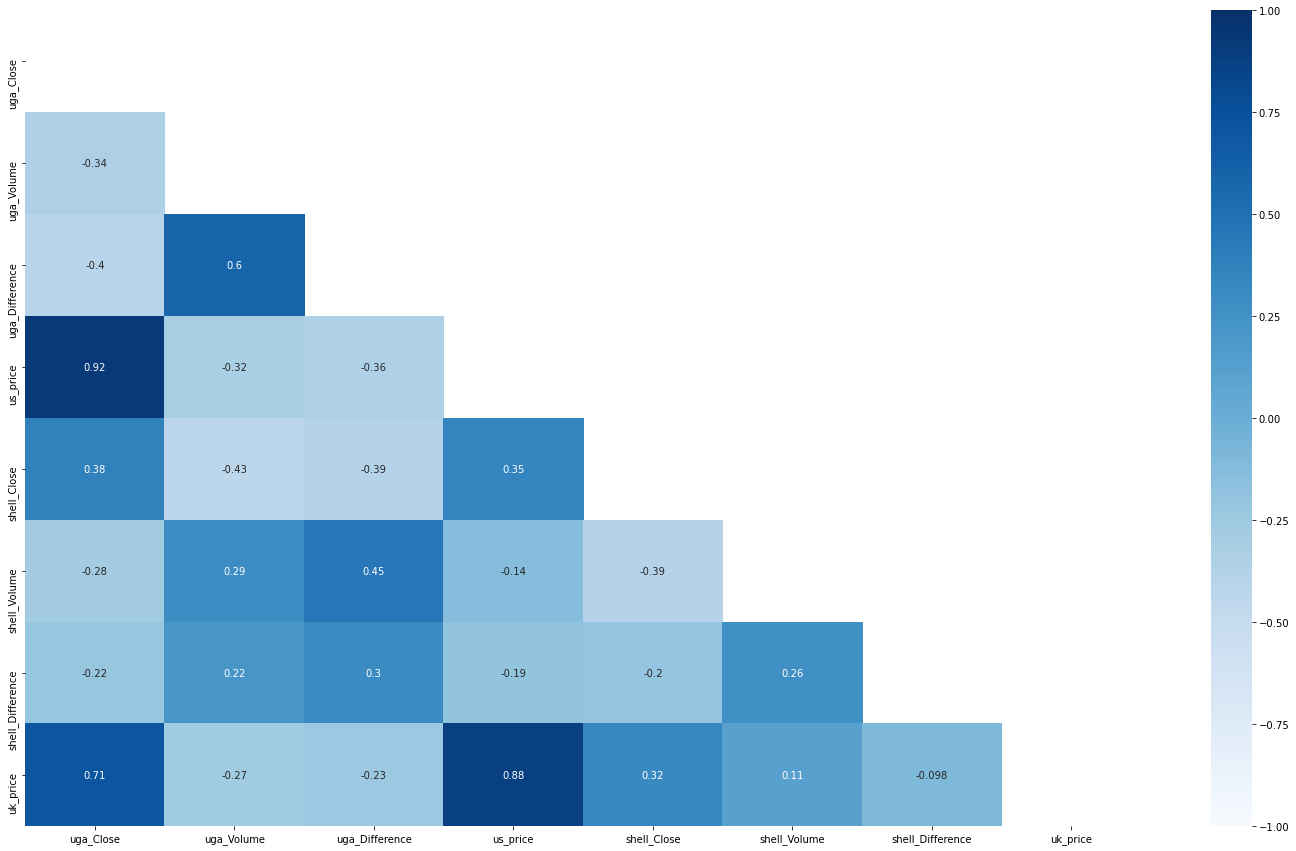

In [7]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(25, 15))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='Blues')

<AxesSubplot:xlabel='us_price', ylabel='uk_price'>

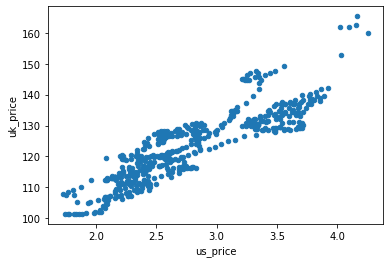

In [8]:
df.plot.scatter(x='us_price', y='uk_price')

<AxesSubplot:xlabel='us_price', ylabel='uga_Close'>

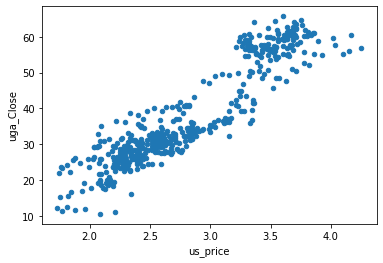

In [9]:
df.plot.scatter(x='us_price', y='uga_Close')

<AxesSubplot:xlabel='us_price', ylabel='uga_Volume'>

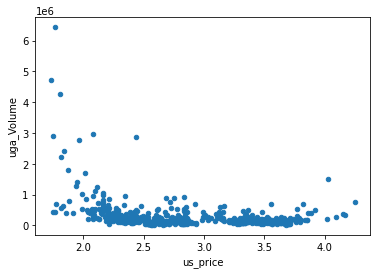

In [10]:
df.plot.scatter(x='us_price', y='uga_Volume')

<AxesSubplot:title={'center':'Historical stock prices of UGA. [16-04-2012 to 11-04-2022]'}, xlabel='Date'>

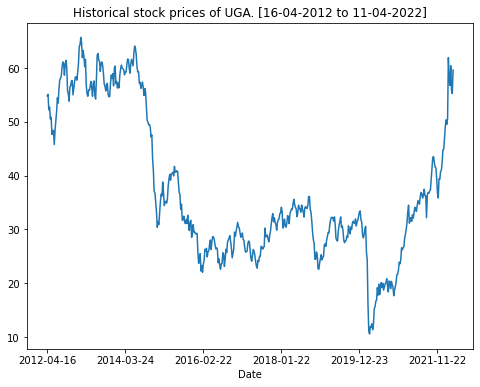

In [11]:
df = df.set_index('Date', drop = True)
df['uga_Close'].plot(figsize=(8,6), title = "Historical stock prices of UGA. [16-04-2012 to 11-04-2022]")

<AxesSubplot:title={'center':'US Fuel Price'}, xlabel='Date'>

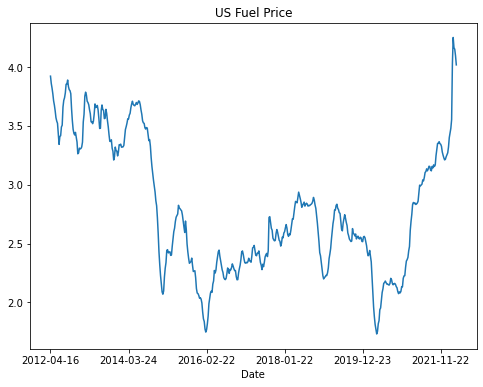

In [12]:
df['us_price'].plot(figsize=(8,6), title = "US Fuel Price")

# Modelling

## Linear Regression Model

In [13]:
conf = SparkConf().setMaster("local").setAppName("Logistic Regression - US fuel Price")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [14]:
csv_file = df.to_csv('/project/DataEngineering/fuel_price.csv', index=False)

In [15]:
df_spark = sqlContext.read.format('com.databricks.spark.csv').options(header = 'true', inferschema = 'true').load('/project/DataEngineering/fuel_price.csv')
df_spark.printSchema()
df_spark.show(10)

root
 |-- uga_Close: double (nullable = true)
 |-- uga_Volume: double (nullable = true)
 |-- uga_Difference: double (nullable = true)
 |-- us_price: double (nullable = true)
 |-- shell_Close: double (nullable = true)
 |-- shell_Volume: double (nullable = true)
 |-- shell_Difference: double (nullable = true)
 |-- uk_price: double (nullable = true)

+---------+----------+------------------+--------+-----------+------------+------------------+------------------+
|uga_Close|uga_Volume|    uga_Difference|us_price|shell_Close|shell_Volume|  shell_Difference|          uk_price|
+---------+----------+------------------+--------+-----------+------------+------------------+------------------+
|54.849998|  517500.0|3.1175990197848327|   3.923|     2136.5|   9858753.0|3.9550666978703486|        142.172754|
|55.119999|  412200.0|2.3222043236974597|   3.861|     2188.0| 2.0392958E7| 5.324497257769653|         141.75902|
|52.259998|  694200.0| 6.486797033555174|   3.821|     2142.0| 1.3495471E7|  4.1

In [16]:
independent_variables = ['uga_Close', 'uga_Volume', 'uga_Difference','shell_Close', 'shell_Volume', 'shell_Difference', 'uk_price']
dependent_variable = ['us_price']
us_fuel_price_df = df_spark.select( independent_variables + dependent_variable ) 
for i in us_fuel_price_df.columns:
        print( "Correlation to us_price for ", i, us_fuel_price_df.stat.corr('us_price', i))

Correlation to us_price for  uga_Close 0.9228946808558269
Correlation to us_price for  uga_Volume -0.31975863685433004
Correlation to us_price for  uga_Difference -0.3569380532582372
Correlation to us_price for  shell_Close 0.35409973866872035
Correlation to us_price for  shell_Volume -0.14009347828123045
Correlation to us_price for  shell_Difference -0.19315139118115923
Correlation to us_price for  uk_price 0.8796047655913473
Correlation to us_price for  us_price 1.0


In [17]:
multivariate_feature_columns = ['uk_price', 'shell_Close', 'uga_Difference']
multivariate_label_column = 'us_price'
vector_assembler = VectorAssembler(inputCols = multivariate_feature_columns, outputCol = 'features')
us_fuel_price_features_df = vector_assembler.transform(us_fuel_price_df).select(['features', multivariate_label_column])
us_fuel_price_features_df.head(10)

[Row(features=DenseVector([142.1728, 2136.5, 3.1176]), us_price=3.923),
 Row(features=DenseVector([141.759, 2188.0, 2.3222]), us_price=3.861),
 Row(features=DenseVector([141.0042, 2142.0, 6.4868]), us_price=3.821),
 Row(features=DenseVector([140.1365, 2067.0, 2.9763]), us_price=3.773),
 Row(features=DenseVector([138.2866, 1982.0, 3.5213]), us_price=3.713),
 Row(features=DenseVector([135.7714, 2016.0, 2.7505]), us_price=3.676),
 Row(features=DenseVector([134.3746, 1984.0, 8.7896]), us_price=3.628),
 Row(features=DenseVector([134.0583, 2035.0, 3.3078]), us_price=3.57),
 Row(features=DenseVector([133.6676, 2117.5, 2.8914]), us_price=3.541),
 Row(features=DenseVector([131.991, 2100.0, 6.0699]), us_price=3.522)]

In [18]:
train_df, test_df = us_fuel_price_features_df.randomSplit([0.8, 0.2], seed=48)
train_df.count(), test_df.count()

(429, 92)

In [19]:
linear_regression = LinearRegression(featuresCol = 'features', labelCol = multivariate_label_column)
linear_regression_model = linear_regression.fit(train_df)

In [20]:
print("Model Coefficients: " + str(linear_regression_model.coefficients))
print("Intercept: " + str(linear_regression_model.intercept))
training_summary = linear_regression_model.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)
print("R-SQUARED: %f" % training_summary.r2)
print("TRAINING DATASET DESCRIPTIVE SUMMARY: ")
train_df.describe().show()
print("TRAINING DATASET RESIDUALS: ")
training_summary.residuals.show()

Model Coefficients: [0.041296310956564414,3.2443270073740675e-05,-0.020362818606144313]
Intercept: -2.251452150133435
RMSE: 0.250731
R-SQUARED: 0.797776
TRAINING DATASET DESCRIPTIVE SUMMARY: 
+-------+------------------+
|summary|          us_price|
+-------+------------------+
|  count|               429|
|   mean|2.7997156177156186|
| stddev|0.5582105406769086|
|    min|             1.731|
|    max|             4.252|
+-------+------------------+

TRAINING DATASET RESIDUALS: 
+--------------------+
|           residuals|
+--------------------+
| 0.16019019486114794|
|-0.02757376633542874|
|-0.07189926139968894|
| 0.09327048931096105|
| 0.06506065431664099|
| 0.06828510102514396|
| 0.07876598724249928|
| 0.42111961420488875|
|  0.1430468587612732|
| 0.19646228840186097|
| 0.16986141560842016|
| 0.07858043519374203|
|-0.03021025960977...|
|-0.11883172077355719|
| 0.10013679737329717|
| 0.08863672732242334|
| 0.11501774899993533|
| 0.07262556711822832|
| 0.15271115949761693|
| 0.1769529

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [21]:
# Evaluate the performance of our Linear Regression Model on the Test DataFrame
test_summary = linear_regression_model.evaluate(test_df)
print("RMSE on Test Data = %g" % test_summary.rootMeanSquaredError)
print("R-SQUARED on Test Data = %g" % test_summary.r2)

RMSE on Test Data = 0.267042
R-SQUARED on Test Data = 0.797928


In [22]:
# Stop the Spark Context
sc.stop()